In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Data setup: (Provided for you)
We are using the MNIST dataset from [Pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). For the sake of simplicity, we are only using only the first 2000 samples from the test set. Here, we have normalized the images to the range [0, 1], then reshaped each image to a tensor vector of size 784 and stack them together to get an array of 2000x784.

In [2]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the first 2000 samples
data = mnist_data.data[:2000].float()
labels = mnist_data.targets[:2000]

# Normalize the data to [0, 1]
data /= 255.0

# Reshape the data
n, d = data.size(0), data.size(1) * data.size(2)  # n = 2000, d = 784
X = data.view(n, d)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### a. Eigendecomposition 


i.   Complete the function `eigen_decomp()`. Take care to:

- Center the input data `X` by subtracting the mean of each feature.
- Calculate the covariance matrix and performs eigendecomposition to obtain eigenvalues and eigenvectors.
- Compute the cumulative variance explained by each component and return it.


ii.   Plot the cumulative explained variance against the number of principal components.

In [3]:
def eigen_decomp(X):
 
  X_center = X - torch.mean(X, dim=0)

  cov_matrix = torch.mm(X_center.t(), X_center) / (X_center.size(0) - 1)

  eigvals, eigvecs = torch.linalg.eig(cov_matrix)

  sorted_indices = torch.argsort(eigvals.real, descending=True)  
  eigvals = eigvals[sorted_indices] 
  eigvecs = eigvecs[:, sorted_indices]

  cumulative_variance_explained = np.cumsum(eigvals.numpy()) / np.sum(eigvals.numpy())
  
  
  return eigvals, eigvecs, cumulative_variance_explained





c:\Users\sriva\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sriva\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


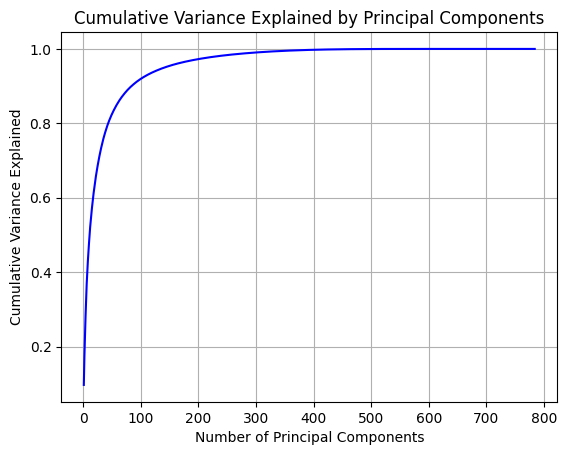

In [4]:
eigvals, eigvecs, cumulative_variance_explained = eigen_decomp(X)

# Plot the cumulative variance against the principal components
##TODO##

plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, color='b') 
plt.xlabel('Number of Principal Components') 
plt.ylabel('Cumulative Variance Explained') 
plt.title('Cumulative Variance Explained by Principal Components') 
plt.grid()


Each principal component explains some part of the variance of the data. Discarding some of them reduces the amount of variance that we can capture in the model. I think it can help in preventing model overfit the data but it can lead to some loss in accuracy of data.



the function `pca_reconstruction_error()` will:
- Center the input data `X` by subtracting the mean of each feature (again).
- Projects `X` onto the top `p` principal components, reconstructs it.
- Compute the normalized reconstruction error in terms of the Frobenius norm, i.e. $e_{p} = \frac{\|x - \hat{x}_p\|_{F}}{\|x\|_{F}}$, where $x$ denotes the input matrix and $\hat{x}_p$ denotes the recovered matrix associated to each $p$.


In [5]:
def pca_reconstruction_error(X, p, eigvecs):
   
   X_centered = X - torch.mean(X, dim=0) 

   eigvecs_real = eigvecs.real
   
   top_p_eigvecs = eigvecs_real[:, :p] 
   X_projected = torch.mm(X_centered, top_p_eigvecs) 
   
   X_reconstructed = torch.mm(X_projected, top_p_eigvecs.t()) 
   X_reconstructed = X_reconstructed + torch.mean(X, dim=0) 

   frob_norm_diff = torch.norm(X - X_reconstructed, p='fro') 
   frob_norm_X = torch.norm(X, p='fro') 
   error = frob_norm_diff / frob_norm_X 
   
   return error.item(), X_reconstructed

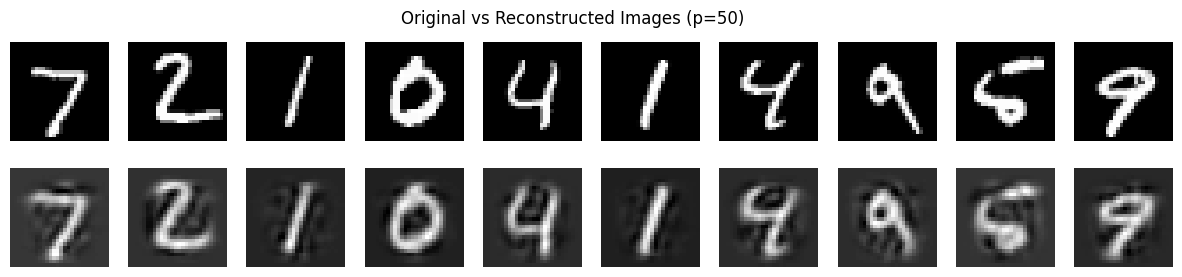

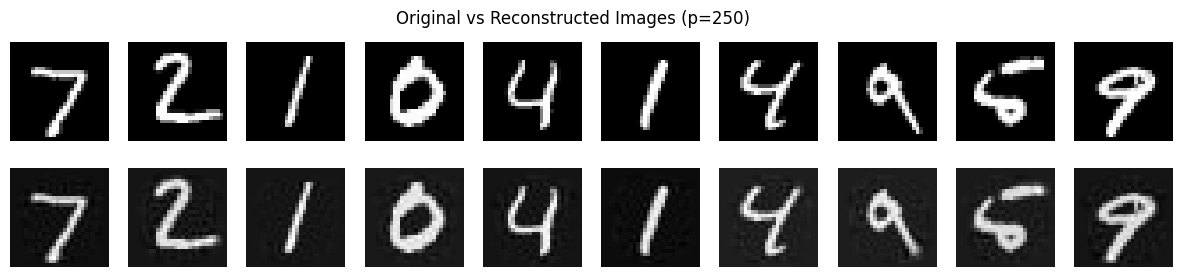

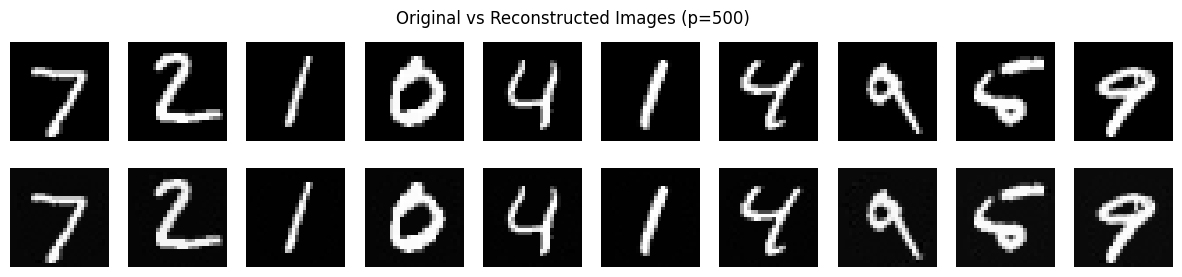

Frobenius Norm Errors: [0.3276287615299225, 0.10058772563934326, 0.012204413302242756]


In [6]:
### Driver code for the previousky defined functions
frobenius_norm = []

# Evaluate for p = 50, 250, 500
for p in [50, 250, 500]:
    error, X_reconstructed = pca_reconstruction_error(X, p, eigvecs)
    frobenius_norm.append(error)

    # Visualize some original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f'Original vs Reconstructed Images (p={p})')
    plt.show()

print(f"Frobenius Norm Errors: {frobenius_norm}")

### Noisy Data Generation 

i.   Complete the function `mnist_noised()` to generate noisy versions of the mnist data.

ii.   Visualize the noisy images and compare them with their corresponding original images.

iii.   Plot the cumulative explained variance of the **noisy data** along with the **original data** versus the number of components.

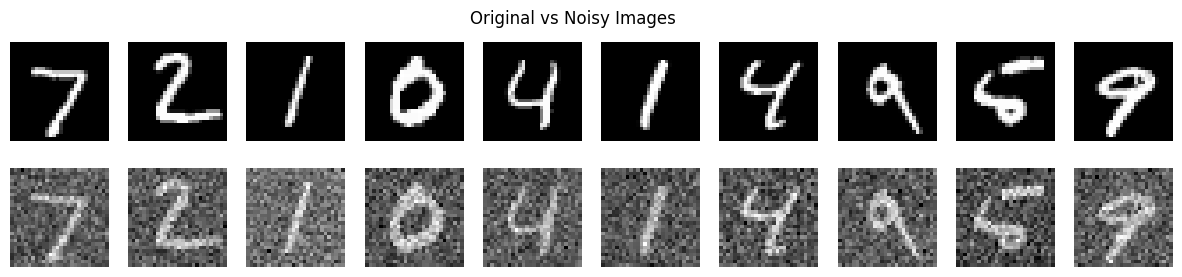

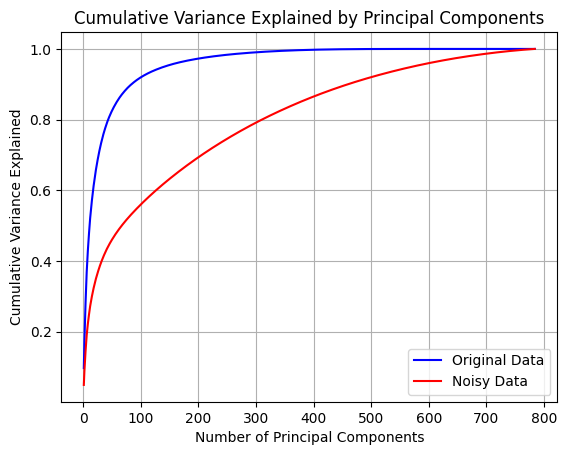

In [37]:
# Add Gaussian noise
def mnist_noised(X, noise_var=0.25):
   """
    Adds Gaussian noise to the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): The variance of the Gaussian noise to be added. Default is 0.25.

    Returns:
        torch.Tensor: A tensor with Gaussian noise added to each element of `X`..
   """
   noise = torch.randn_like(X) * noise_var

   X_noised = X + noise

   return X_noised

# Add Gaussian noise to the data
noisy_data = mnist_noised(X)

# Plot some original and noisy images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_data[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original vs Noisy Images')
plt.show()

# Compute eigen decomposition for the noisy data
eigvals_noisy, eigvecs_noisy, cumulative_variance_explained_noisy = eigen_decomp(noisy_data)

# Plot the cumulative variance for noisy data and original data
##TODO##

plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, color='b', label='Original Data') 
plt.plot(range(1, len(cumulative_variance_explained_noisy) + 1), cumulative_variance_explained_noisy, color='r', label='Noisy Data') 
plt.xlabel('Number of Principal Components') 
plt.ylabel('Cumulative Variance Explained') 
plt.title('Cumulative Variance Explained by Principal Components') 
plt.legend() 
plt.grid() 
plt.show()


The two plots are not similar as in the noisy data the noise has distributed the variance across the components so the first few components are not able to explain it as properly as in the original data, so the noisy data graph rises gradually as compared to original data graph

###  Image Denoising 



i.   the function `pca_reconstruction_noisy()`will:
- Add Gaussian noise of a specified variance ($\sigma^{2}$) to the original data.
- Compute the eigen decomposition on the noisy data, retaining only the top `p` principal components.
- Calculate the reconstruction error to quantify the quality of denoising.

ii. Plot the denoised images agianst the noisy data for visual comparison.



In [ ]:
def pca_reconstruction_noisy(X, noise_var=0.05, p=100):
  

   X_noised = mnist_noised(X, noise_var=noise_var)
   X_centered = X_noised - torch.mean(X_noised, dim=0)
   
   covariance_matrix = torch.mm(X_centered.t(), X_centered) / (X_centered.size(0) - 1)
   eigvals, eigvecs = torch.linalg.eig(covariance_matrix)

   sorted_indices = torch.argsort(eigvals.real, descending=True) 
   eigvals = eigvals[sorted_indices] 
   eigvecs = eigvecs[:, sorted_indices]

   top_p_eigvecs = eigvecs[:, :p].real 
   X_projected = torch.mm(X_centered, top_p_eigvecs)

   X_reconstructed = torch.mm(X_projected, top_p_eigvecs.t()) 
   X_reconstructed = X_reconstructed + torch.mean(X_noised, dim=0)
   
   frob_norm_diff = torch.norm(X - X_reconstructed, p='fro') 
   frob_norm_X = torch.norm(X, p='fro') 
   error = frob_norm_diff / frob_norm_X

   return error.item(), X_reconstructed

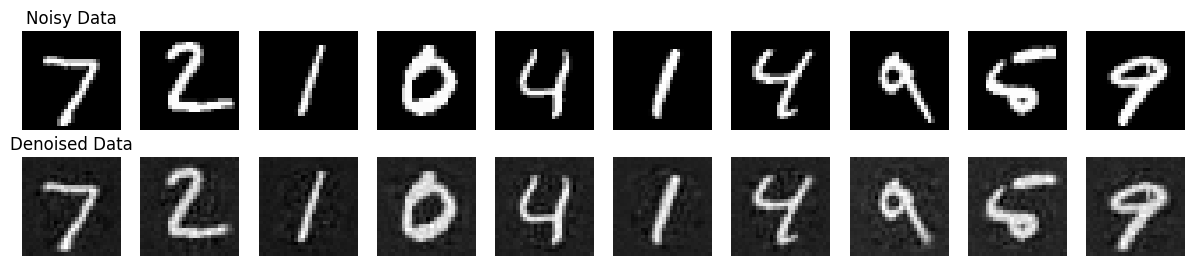

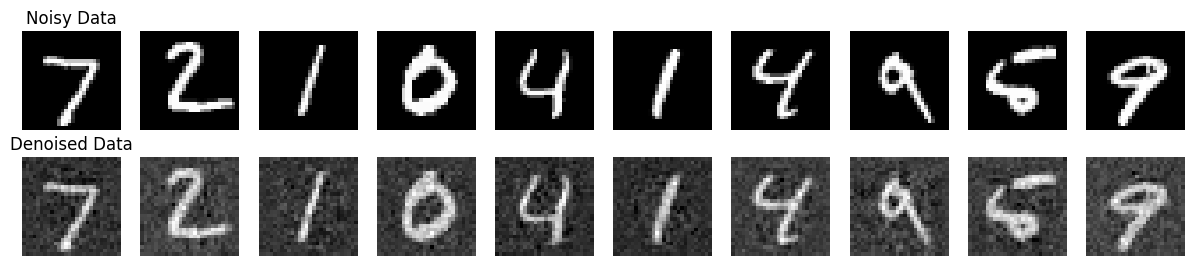

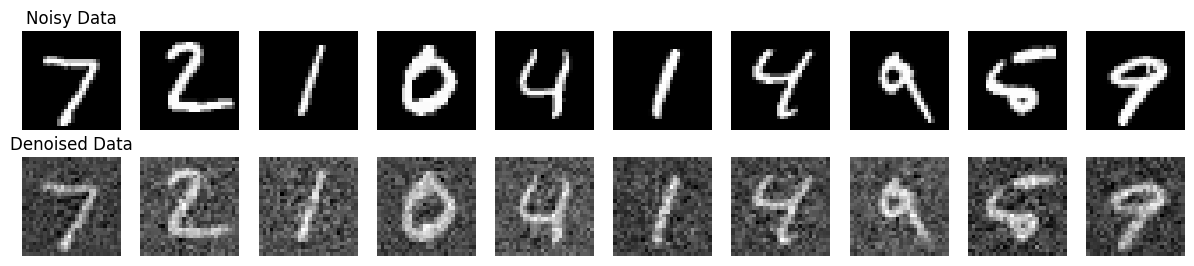

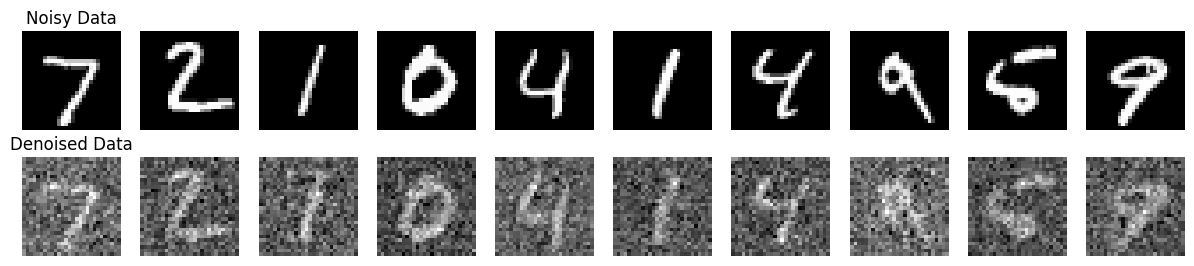

Reconstruction Errors for different noise levels: [0.16007724404335022, 0.33592432737350464, 0.5492987632751465, 1.093801498413086]


In [9]:
### Driver code for the previousky defined functions
noise_levels = [0.05, 0.15, 0.25, 0.5]
errors = []

for noise_var in noise_levels:
    error, X_reconstructed = pca_reconstruction_noisy(X, noise_var, p=200)
    errors.append(error)

    # Visualize some of the recovered images
    ##TODO##
    fig, axes = plt.subplots(2, 10, figsize=(15, 3)) 
    for i in range(10): 
        # Noisy data
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray') 
        axes[0, i].axis('off') 
        
        # Denoised data 
        axes[1, i].imshow(X_reconstructed[i].detach().numpy().reshape(28, 28), cmap='gray') 
        axes[1, i].axis('off') 
    
    axes[0, 0].set_title('Noisy Data') 
    axes[1, 0].set_title('Denoised Data') 
    plt.show()

print(f"Reconstruction Errors for different noise levels: {errors}")